# Tumoroscope in PyMC

## Setup

In [1]:
import os
from dataclasses import dataclass
from math import ceil
from pathlib import Path

import aesara.tensor as at
import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Arviz config.
az.rcparams.rcParams["stats.hdi_prob"] = 0.89

# Models directory.
models_dir = Path("models")
if not models_dir.exists():
    models_dir.mkdir()

## Introduction

![tumoroscope overview](tumoroscope-overview.png)

## Model

In [4]:
@dataclass
class TumoroscopeData:
    """Tumoroscope model data."""

    K: int  # number of clones
    S: int  # number of spots
    M: int  # number of mutation positions
    F: np.ndarray  # Prevelance of clones from bulk-DNA seq.
    cell_counts: np.ndarray  # Number of cell counted per spot
    C: np.ndarray  # Zygosity per position and clone
    D_obs: np.ndarray | None  # Read count per position per spot
    A_obs: np.ndarray | None  # Alternated reads per position per spot
    zeta_s: float = 1.0  # Pi hyper-parameter
    F_0: float = 1.0  # "pseudo-frequency" for lower bound on clone proportion
    l: float = 100  # Scaling factor to discretize F
    r: float = 0.1  # shape parameter for Gamma over Phi
    p: float = 1.0  # rate parameter for Gamma over Phi


def _prefixed_index(n: int, prefix: str) -> list[str]:
    return [f"{prefix}{i}" for i in np.arange(n)]


def _check_tumoroscope_data(data: TumoroscopeData) -> None:
    assert data.K > 0 and data.S > 0 and data.M > 0

    assert np.isclose(data.F.sum(), 1.0)
    assert data.F.ndim == 1
    assert data.F.shape[0] == data.K

    assert data.cell_counts.shape == (data.S,)
    assert np.all(data.cell_counts > 0)

    assert np.all(data.C >= 0.0) and np.all(data.C <= 1.0)
    assert data.C.shape == (data.M, data.K)

    if data.D_obs is not None:
        assert data.D_obs.shape == (data.M, data.S)

    if data.A_obs is not None:
        assert data.A_obs.shape == (data.M, data.S)

    assert data.zeta_s > 0.0
    assert data.F_0 > 0.0
    assert data.l > 0.0
    assert data.r > 0.0 and data.p > 0.0


def _make_tumoroscope_model_coords(data: TumoroscopeData) -> dict[str, list[str]]:
    coords = {
        "clone": _prefixed_index(data.K, "c"),
        "spot": _prefixed_index(data.S, "s"),
        "position": _prefixed_index(data.M, "p"),
    }
    return coords


def tumoroscope(data: TumoroscopeData, fixed: bool = False) -> pm.Model:
    _check_tumoroscope_data(data)
    coords = _make_tumoroscope_model_coords(data)
    with pm.Model(coords=coords) as model:
        ζ_s = pm.ConstantData("ζ_s", data.zeta_s)
        ℓ = pm.ConstantData("ℓ", data.l)
        F_0 = pm.ConstantData("F0", data.F_0)
        F = pm.ConstantData("F", data.F, dims="clone")
        if not fixed:
            Λ = pm.ConstantData("Λ", data.cell_counts, dims="spot")
        r = pm.ConstantData("r", data.r)
        p = pm.ConstantData("p", data.p)
        C = pm.ConstantData("C", data.C, dims=("position", "clone"))

        F_prime = pm.Deterministic("F_prime", ℓ * at.ceil(20 * F) / 20, dims="clone")

        Π = pm.Beta("Π", alpha=ζ_s / data.K, beta=1, dims=("spot", "clone"))
        Z = pm.Bernoulli("Z", p=Π, dims=("spot", "clone"))
        G = pm.Gamma(
            "G", (F_prime[None, :] ** Z) * (F_0 ** (1 - Z)), 1, dims=("spot", "clone")
        )
        H = pm.Deterministic("H", G / G.sum(axis=1)[:, None], dims=("spot", "clone"))

        if fixed:
            N = pm.ConstantData("N", data.cell_counts, dims="spot")
        else:
            N = pm.Poisson("N", Λ, dims="spot")
        Φ = pm.Gamma("Φ", r, p, dims=("position", "clone"))

        D = pm.Poisson(
            "D", N * H.dot(Φ.T).T, dims=("position", "spot"), observed=data.D_obs
        )
        _A_num = H.dot((Φ * C).T).T
        _A_denom = H.dot(Φ.T).T
        A_prob = pm.Deterministic(
            "A_prob", _A_num / _A_denom, dims=("position", "spot")
        )
        A = pm.Binomial("A", D, A_prob, dims=("position", "spot"), observed=data.A_obs)
    return model

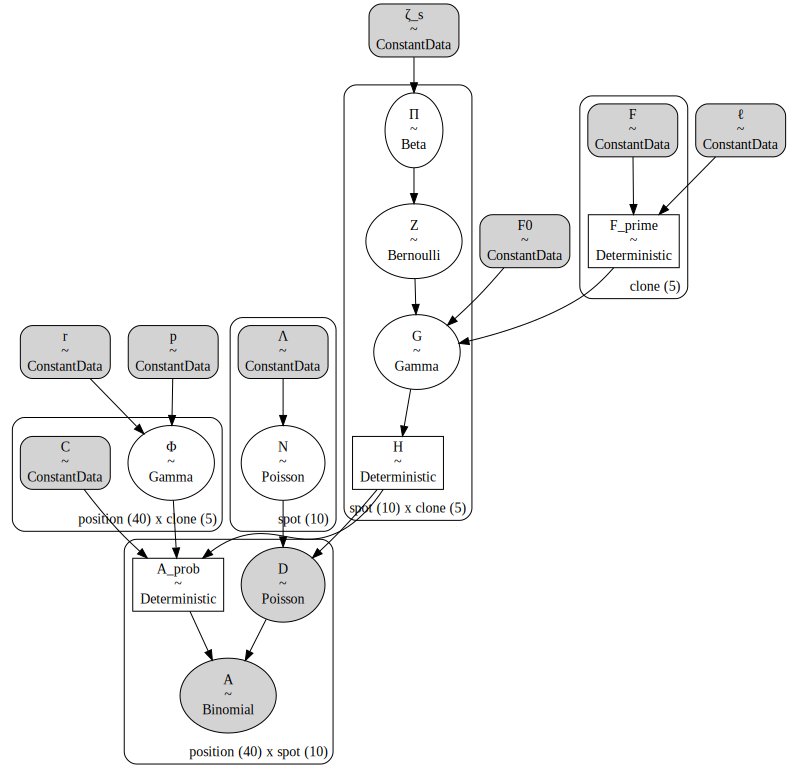

In [5]:
np.random.seed(234)
mock_tumor_data = TumoroscopeData(
    K=5,
    S=10,
    M=40,
    F=np.ones(5) / 5.0,
    cell_counts=np.random.randint(1, 20, size=10),
    C=np.random.beta(2, 2, size=(40, 5)),
    D_obs=np.random.randint(2, 20, size=(40, 10)),
    A_obs=np.random.randint(2, 20, size=(40, 10)),
)
pm.model_to_graphviz(tumoroscope(mock_tumor_data))

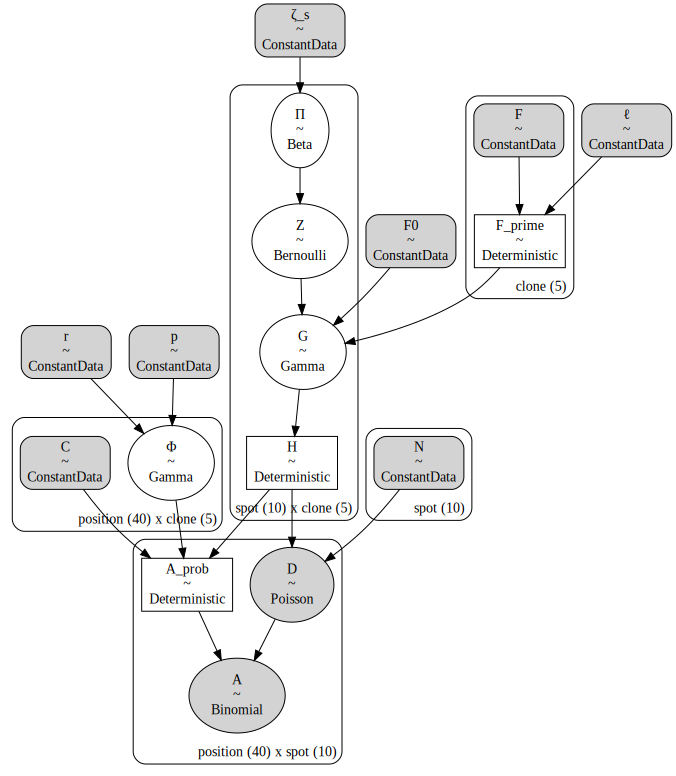

In [6]:
pm.model_to_graphviz(tumoroscope(mock_tumor_data, fixed=True))

Possible improvements

- explore prior distributions over the current user-supplied hyper-parameters
- utilize spatial relationships in the estimation of clonal distributions per spot
- a hierarchical structure to share information
- try to use Dirichlet for $P(H|F^\prime,F_0,Z)$ like the Methods explains

## Prior predictive sampling

In [7]:
example_input_data = TumoroscopeData(
    K=5,
    S=10,
    M=40,
    F=np.array([0.01, 0.05, 0.15, 0.3, 0.49]),
    cell_counts=np.ones(10) * 5,
    C=np.random.choice([0, 0.5, 1.0], size=(40, 5), replace=True),
    D_obs=None,
    A_obs=None,
    r=0.19,
    p=1,
)

with tumoroscope(example_input_data) as m:
    prior_pred = pm.sample_prior_predictive(
        500,
        var_names=["D", "A", "H", "G", "Z", "Π", "Φ", "N", "A_prob"],
        random_seed=123,
    )

Sampling: [A, D, G, N, Z, Π, Φ]


In [8]:
prior_pred.constant_data["Λ"].values

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

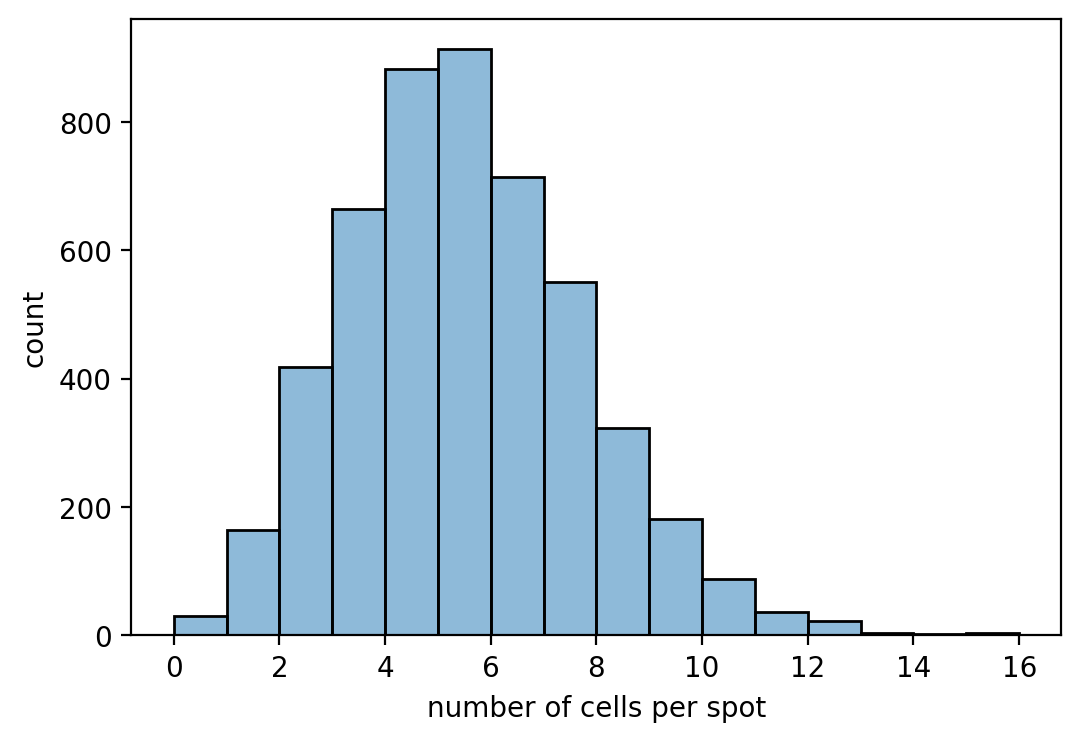

In [9]:
_, ax = plt.subplots(figsize=(6, 4))
sns.histplot(prior_pred.prior["N"].values.flatten(), alpha=0.5, binwidth=1, ax=ax)
ax.set_xlabel("number of cells per spot")
ax.set_ylabel("count")
plt.show()

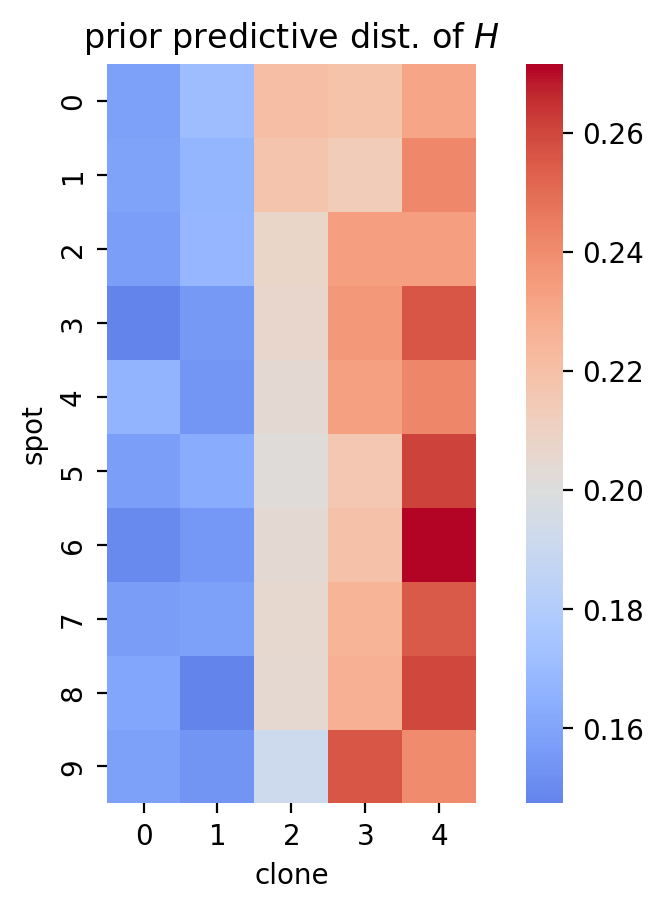

In [10]:
H_mean = prior_pred.prior["H"].values.squeeze().mean(axis=0)
ax = sns.heatmap(
    data=H_mean, cmap="coolwarm", center=1 / mock_tumor_data.K, square=True
)
ax.set_xlabel("clone")
ax.set_ylabel("spot")
ax.set_title("prior predictive dist. of $H$")
plt.show()

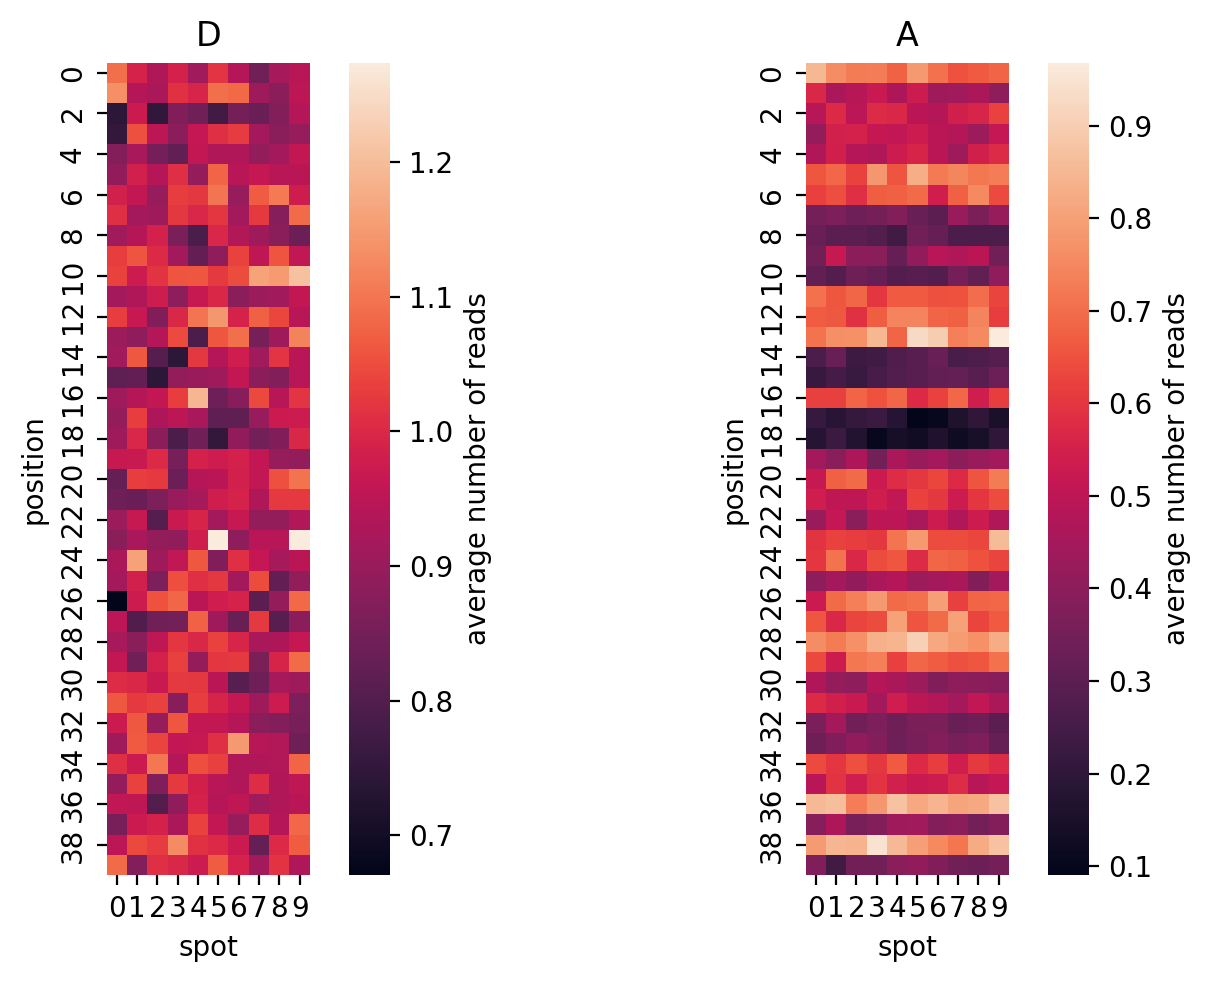

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
for ax, var_name in zip(axes, ["D", "A"]):
    var_prior_mean = prior_pred.prior[var_name].mean(axis=(0, 1)).values
    sns.heatmap(
        var_prior_mean,
        square=True,
        cbar_kws={"label": "average number of reads"},
        ax=ax,
    )
    ax.set_xlabel("spot")
    ax.set_ylabel("position")
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

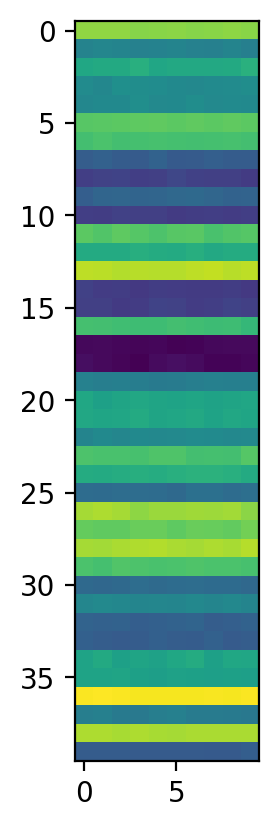

In [12]:
plt.imshow(prior_pred.prior["A_prob"].mean(dim=("chain", "draw")))

Average number of reads *per spot*.

In [13]:
prior_pred.prior["D"].mean(axis=(0, 1)).sum(axis=0).values

array([37.208, 38.7  , 37.204, 38.064, 38.834, 39.186, 38.212, 37.386,
       37.636, 39.206])

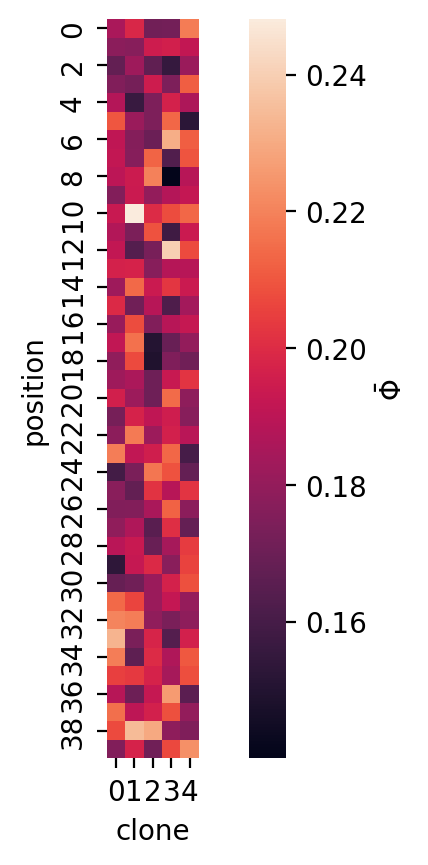

In [14]:
phi_prior_mean = prior_pred.prior["Φ"].mean(axis=(0, 1)).values
ax = sns.heatmap(phi_prior_mean, square=True, cbar_kws={"label": r"$\bar{\Phi}$"})
ax.set_xlabel("clone")
ax.set_ylabel("position")
plt.show()

## Simulation experiments

### Simple simulation

This simulation is purposefully simple to give the model the best chance at working if it correctly specified.
There are only two clones, one with mutations and one with none.
There are many cells per spot to increase the odds of mixtures of clones.
The number of reads per position per clone is fixed at 3 per cell and the number of alternative reads is perfectly aligned with the zygosity of the mutation in the clone.

In [15]:
# Set seed for reproducible results.
np.random.seed(8383)

# Set true underlying constants.
N_CLONES = 2
N_SPOTS = 20
n_positions = 300  # changes below depending on random sampling

# Number of cells counted in each spot between 2 and 8 cells.
cell_counts = np.random.randint(10, 20, size=N_SPOTS)

# True mutations for each clone.
clone_mutations = np.hstack(
    [
        np.random.binomial(1, p, size=(n_positions, 1)) for p in [0.0, 0.5]
    ]  # , 0.5, 0.3, 0.3]]
)
# Drop positions without any mutations.
clone_mutations = clone_mutations[clone_mutations.sum(axis=1) > 0.0, :]
clone_mutations = clone_mutations[clone_mutations.mean(axis=1) < 1.0, :]
n_positions = clone_mutations.shape[0]
print(f"Number of positions: {n_positions}")

# Assign probability distribution over spots for each clone.
clone_props_params = [(1, 3), (3, 1)]
clone_ratios = np.array([0.5, 0.5])
spots_x = np.linspace(0, 1, N_SPOTS)
clone_proportions = np.hstack(
    [scipy.stats.beta(a, b).pdf(spots_x)[:, None] for a, b in clone_props_params]
)
clone_proportions = clone_proportions * clone_ratios
clone_proportions = clone_proportions / clone_proportions.sum(axis=1)[:, None]

# True fraction of clones taken from the underlying distributions.
F = np.array([scipy.stats.beta(a, b).pdf(spots_x).sum() for a, b in clone_props_params])
F = F * clone_ratios
F = F / F.sum()

_cell_labels: list[tuple[int, int, int]] = []
clones = np.arange(N_CLONES)
for spot_i in range(N_SPOTS):
    for cell_j in range(cell_counts[spot_i]):
        clone = np.random.choice(clones, size=1, p=clone_proportions[spot_i, :])[0]
        _cell_labels.append((spot_i, cell_j, clone))
cell_labels = pd.DataFrame(_cell_labels, columns=["spot", "cell", "clone"])
cell_labels.head()

Number of positions: 150


,spot,cell,clone
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0


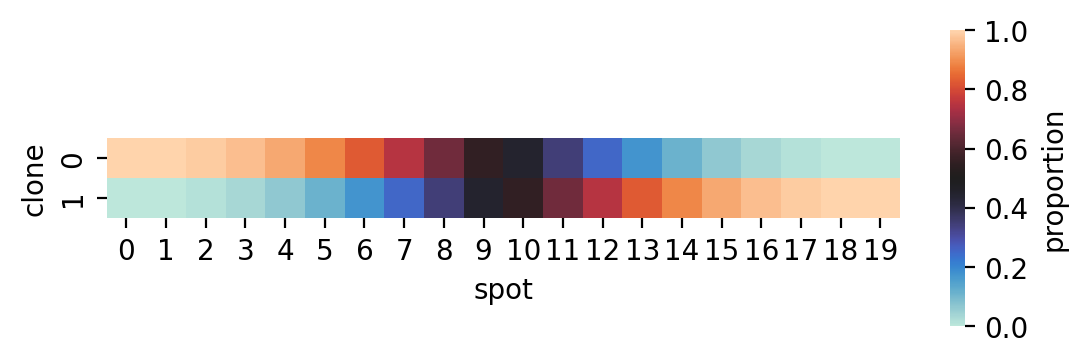

In [16]:
ax = sns.heatmap(
    clone_proportions.T,
    cmap="icefire",
    center=0.5,
    vmin=0,
    vmax=1.0,
    square=True,
    cbar_kws={"shrink": 0.4, "label": "proportion"},
)
ax.set_xlabel("spot")
ax.set_ylabel("clone")
plt.show()

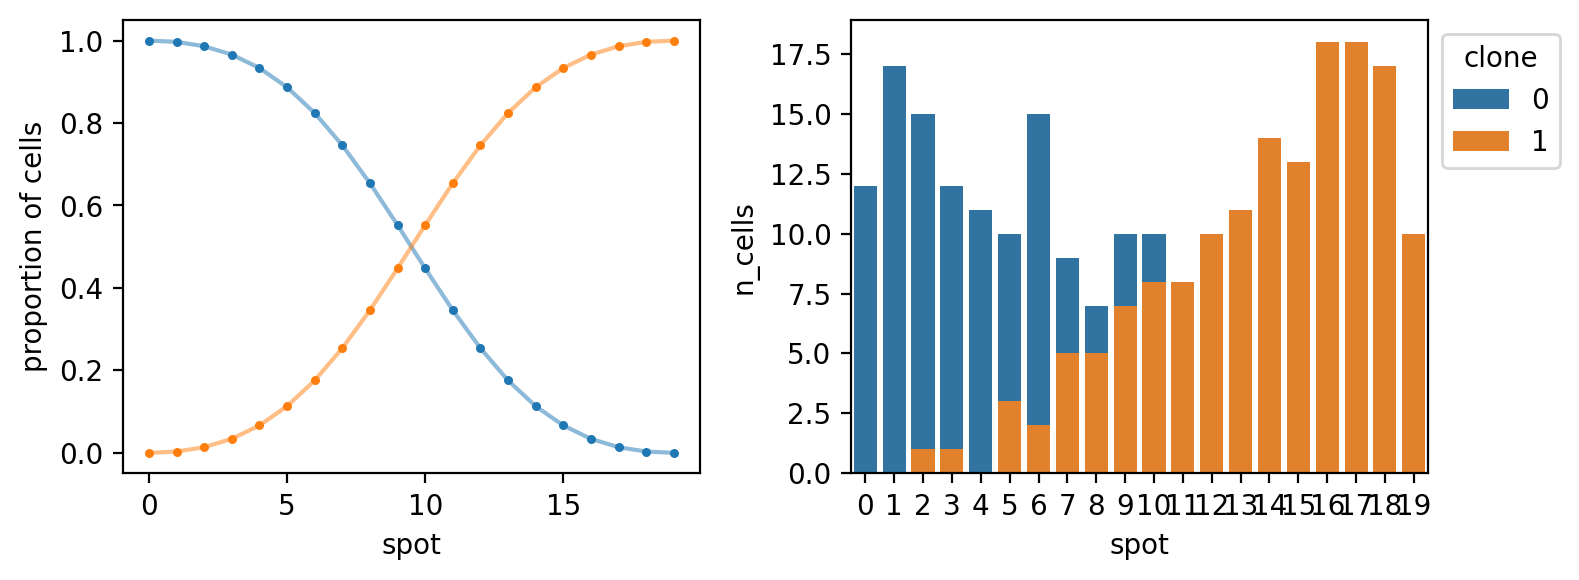

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))

ax = axes[0]
for i in range(clone_proportions.shape[1]):
    x = np.arange(clone_proportions.shape[0])
    ax.plot(x, clone_proportions[:, i], label=f"{i}", alpha=0.5)
    ax.scatter(x, clone_proportions[:, i], s=5)

ax.set_xlabel("spot")
ax.set_ylabel("proportion of cells")

ax = axes[1]
clones_per_spot = (
    cell_labels.groupby(["spot", "clone"])
    .count()
    .reset_index()
    .rename(columns={"cell": "n_cells"})
    .astype({"clone": "category"})
)

sns.barplot(
    data=clones_per_spot, x="spot", y="n_cells", hue="clone", ax=ax, dodge=False
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="clone")
fig.tight_layout()
plt.show()

Actual clone proportions vs. the randomly sampled clone proportions averaging across spots:

In [18]:
F, clone_proportions.mean(axis=0)

(array([0.5, 0.5]), array([0.5, 0.5]))

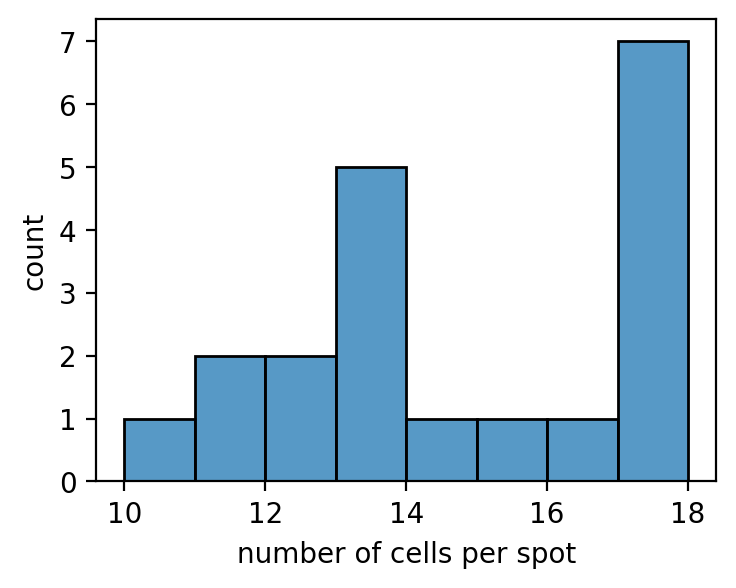

In [19]:
_, ax = plt.subplots(figsize=(4, 3))
sns.histplot(cell_counts.flatten(), binwidth=1, ax=ax)
ax.set_xlabel("number of cells per spot")
ax.set_ylabel("count")
plt.show()

/usr/local/Caskroom/miniconda/base/envs/pymc-tumoroscope/lib/python3.10/site-packages/seaborn/matrix.py:720: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


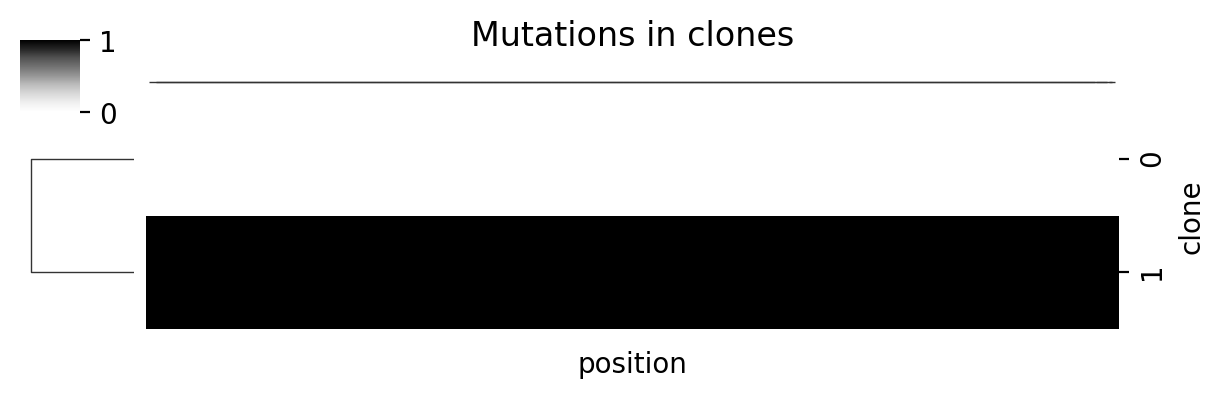

In [20]:
cg = sns.clustermap(
    clone_mutations.T, figsize=(6, 2), dendrogram_ratio=(0.1, 0.15), cmap="Greys"
)
cg.ax_heatmap.set_xlabel("position")
cg.ax_heatmap.set_ylabel("clone")
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.tick_params("x", size=0)
cg.ax_col_dendrogram.set_title("Mutations in clones")
plt.show()

In [21]:
np.random.seed(44)

# Randomly assign zygosity per position for each clone.
zygosity = np.random.choice([0.5, 1.0], size=(n_positions, N_CLONES)) * clone_mutations

# For each cell in each spot, there are 4 reads.
# The number of alternative reads is perfectly calculated based on the
#   zygosity of the clone at the position.

alt_read_counts = np.zeros((n_positions, N_SPOTS, N_CLONES))
tot_read_counts = np.zeros((n_positions, N_SPOTS, N_CLONES))

clone_cell_counts_per_spot = (
    cell_labels.groupby(["spot", "clone"])["cell"]
    .count()
    .reset_index()
    .rename(columns={"cell": "n_cells"})
)

for _, row in clone_cell_counts_per_spot.iterrows():
    # tot_reads = np.random.poisson(10, size=n_positions)
    # alt_reads = np.random.binomial(tot_reads, zygosity[:, row["clone"]])
    tot_reads = (np.ones(n_positions) * 4 * row["n_cells"]).astype(int)
    alt_reads = np.round(zygosity[:, row["clone"]] * tot_reads).astype(int)
    tot_read_counts[:, row["spot"], row["clone"]] = tot_reads
    alt_read_counts[:, row["spot"], row["clone"]] = alt_reads

alt_read_counts = alt_read_counts.sum(axis=2)
tot_read_counts = tot_read_counts.sum(axis=2)
alt_read_counts.shape

(150, 20)

In [22]:
avg_read_cts = tot_read_counts.sum(axis=0).mean()
print(f"average reads per spot: {avg_read_cts:0.2f}")

average reads per spot: 8640.00


For this simulation, the total counts is $4 \times n_\text{cells}$ in each position per spot.
The alternative reads is this number multiplied by the zygosity of the clone and fraction of the clone in the spot.
Clone 0 has no mutations so the alternative read count fades with the number of clone 1 cells.

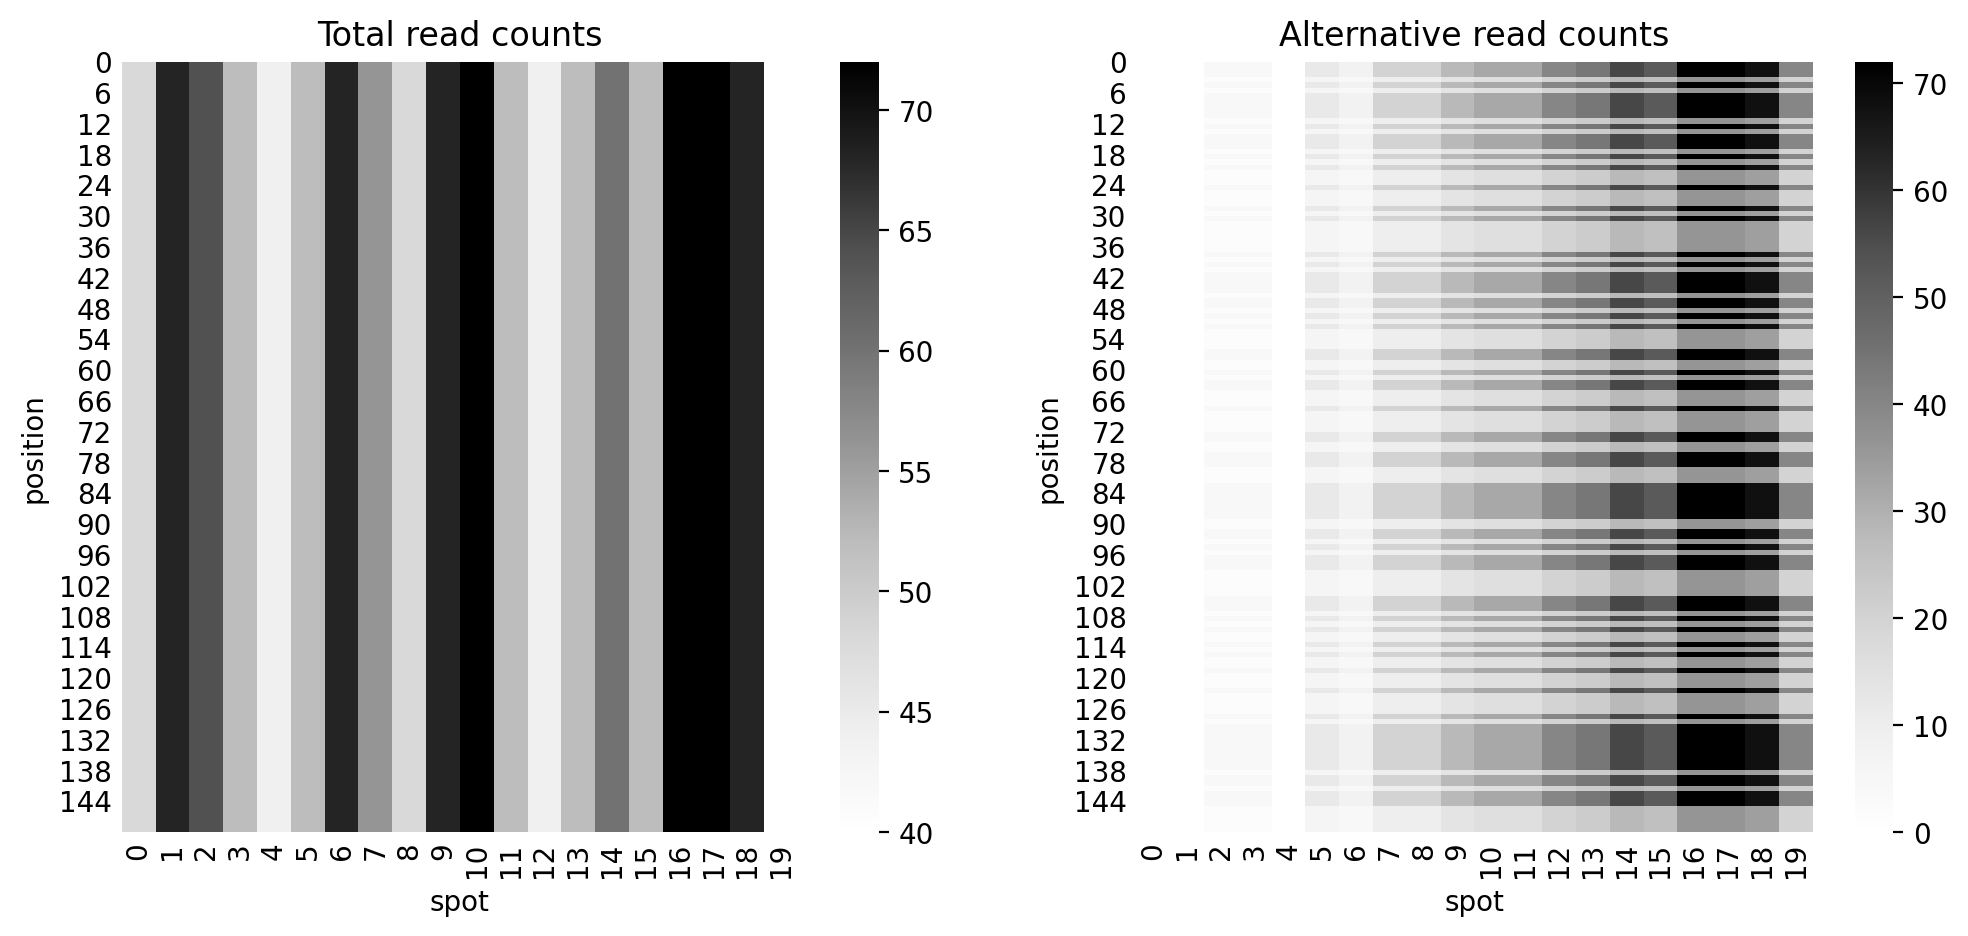

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(tot_read_counts, cmap="Greys", ax=axes[0])
axes[0].set_title("Total read counts")
sns.heatmap(alt_read_counts, cmap="Greys", ax=axes[1])
axes[1].set_title("Alternative read counts")

for ax in axes:
    ax.tick_params(size=0)
    ax.set_xlabel("spot")
    ax.set_ylabel("position")

plt.show()

In [24]:
sim_data = TumoroscopeData(
    K=N_CLONES,
    S=N_SPOTS,
    M=n_positions,
    F_0=1,
    F=F,
    cell_counts=cell_counts,
    C=zygosity,
    D_obs=tot_read_counts,
    A_obs=alt_read_counts,
    zeta_s=N_CLONES * 2,
    r=1,
    p=1,
)

sim_trace_fp = models_dir / "simulation-trace.netcdf"
if False and sim_trace_fp.exists():
    print("Removing trace cache.")
    os.remove(sim_trace_fp)

if sim_trace_fp.exists():
    print("Retrieving cached posterior.")
    sim_trace = az.from_netcdf(sim_trace_fp)
else:
    with tumoroscope(sim_data, fixed=False):
        sim_trace = pm.sample(
            draws=500, tune=1000, chains=4, cores=4, random_seed=10, target_accept=0.9
        )
        pm.sample_posterior_predictive(
            sim_trace, random_seed=7348, extend_inferencedata=True
        )
    sim_trace.to_netcdf(sim_trace_fp)

Retrieving cached posterior.


In [25]:
n_divs = sim_trace.sample_stats.diverging.sum(axis=1).values
print(f"Number of divergences per chain: {n_divs}")

Number of divergences per chain: [0 0 0 0]


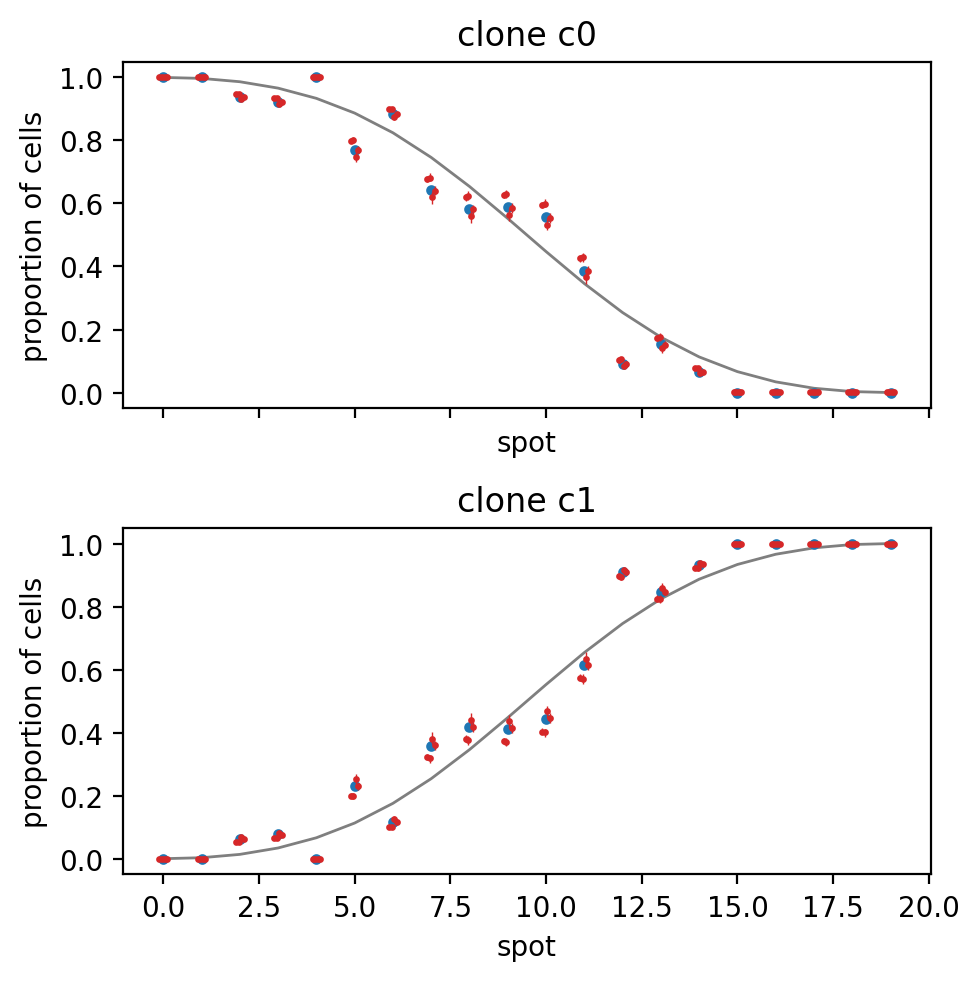

In [26]:
def _frac_clone(s: pd.Series, k: int) -> float:
    return np.mean(s == k)


fig, axes = plt.subplots(nrows=sim_data.K, figsize=(5, 2.5 * sim_data.K), sharex=True)
for clone_i, ax in enumerate(axes.flatten()):
    clone = f"c{clone_i}"
    ax.set_title(f"clone {clone}")

    # Plot true fraction of clones at each spot.
    true_clone_frac = cell_labels.groupby(["spot"])["clone"].apply(
        _frac_clone, k=clone_i
    )
    ax.scatter(
        true_clone_frac.index.tolist(),
        true_clone_frac.values.tolist(),
        c="tab:blue",
        s=8,
        zorder=10,
    )

    # Plot true underlying proportion of clones at each spot.
    spot = np.arange(sim_data.S)
    ax.plot(spot, clone_proportions[:, clone_i], c="tab:grey", lw=1, zorder=5)

    # Plot posterior.
    H = sim_trace.posterior["H"].sel(clone=[clone])
    dx = np.linspace(-0.1, 0.1, len(H.coords["chain"]))
    for chain in H.coords["chain"]:
        _x = spot + dx[chain]
        ax.scatter(_x, H.sel(chain=chain).mean(axis=(0)), c="tab:red", s=2, zorder=20)
        _hdi = az.hdi(H, coords={"chain": [chain]})["H"].values.squeeze()
        ax.vlines(
            x=_x, ymin=_hdi[:, 0], ymax=_hdi[:, 1], lw=0.5, zorder=10, color="tab:red"
        )
    ax.set_xlabel("spot")
    ax.set_ylabel("proportion of cells")

fig.tight_layout()
plt.show()

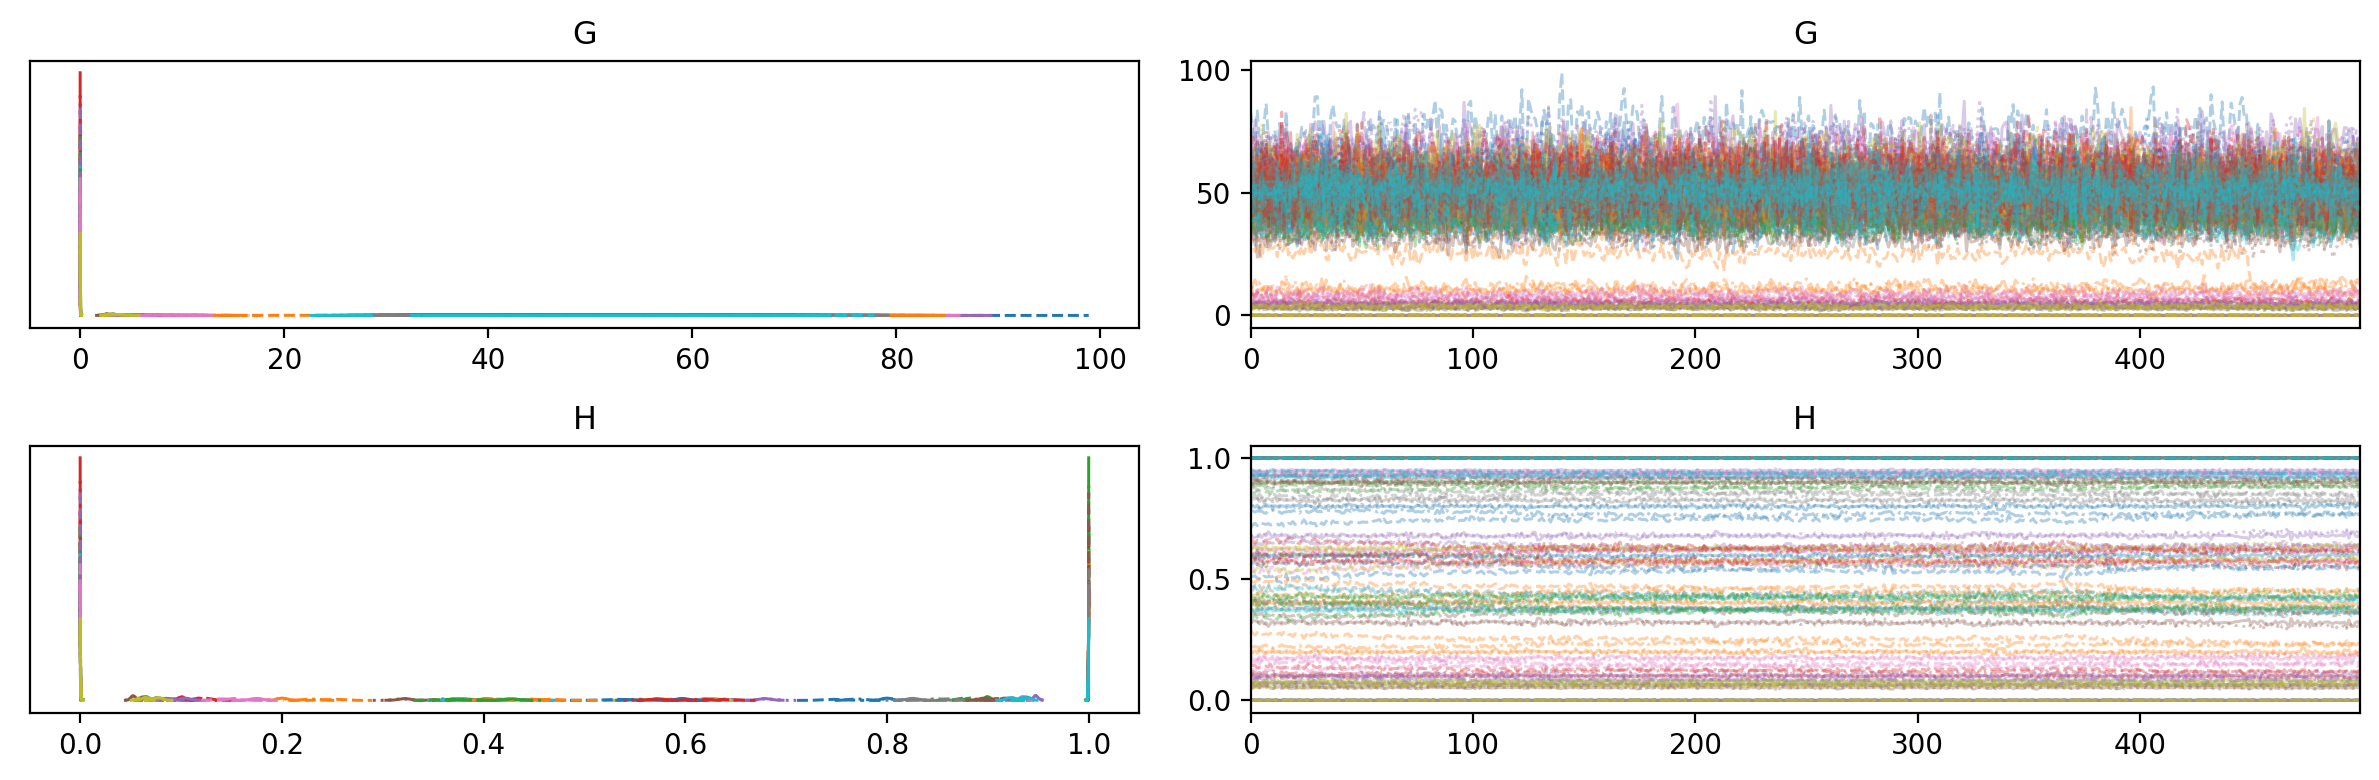

In [27]:
az.plot_trace(sim_trace, var_names=["G", "H"])
plt.tight_layout()

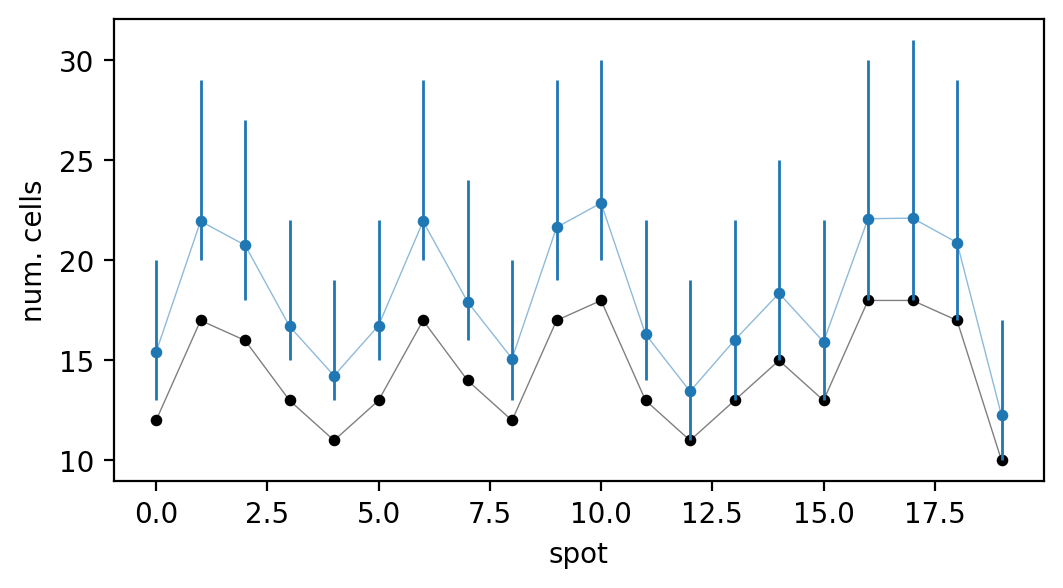

In [28]:
cell_counts_post = az.summary(sim_trace, var_names=["N"]).assign(
    truth=sim_data.cell_counts
)

_, ax = plt.subplots(figsize=(6, 3))
np.arange(len(cell_counts_post))
ax.scatter(x, cell_counts_post["mean"], c="tab:blue", zorder=10, s=10)
ax.plot(x, cell_counts_post["mean"], c="tab:blue", zorder=2, lw=0.5, alpha=0.5)
ax.vlines(
    x,
    cell_counts_post["hdi_5.5%"],
    cell_counts_post["hdi_94.5%"],
    color="tab:blue",
    zorder=10,
    lw=1,
)
ax.set_xlabel("spot")
ax.set_ylabel("num. cells")
ax.scatter(x, cell_counts_post["truth"], c="k", zorder=5, s=10)
ax.plot(x, cell_counts_post["truth"], c="k", zorder=2, lw=0.5, alpha=0.5)

In [29]:
clone_counts = (
    cell_labels.astype({"clone": "category"}).groupby(["spot", "clone"]).count()
)
Z_post_summary = (
    az.summary(sim_trace, var_names=["Z"], kind="stats")
    .assign(mean=lambda d: d["mean"] > 0.5)
    .assign(truth=clone_counts["cell"].values > 0)
)
Z_accuracy = np.mean(Z_post_summary["mean"] == Z_post_summary["truth"])
print(f"accuracy of Z: {Z_accuracy:0.2f}")

accuracy of Z: 0.82


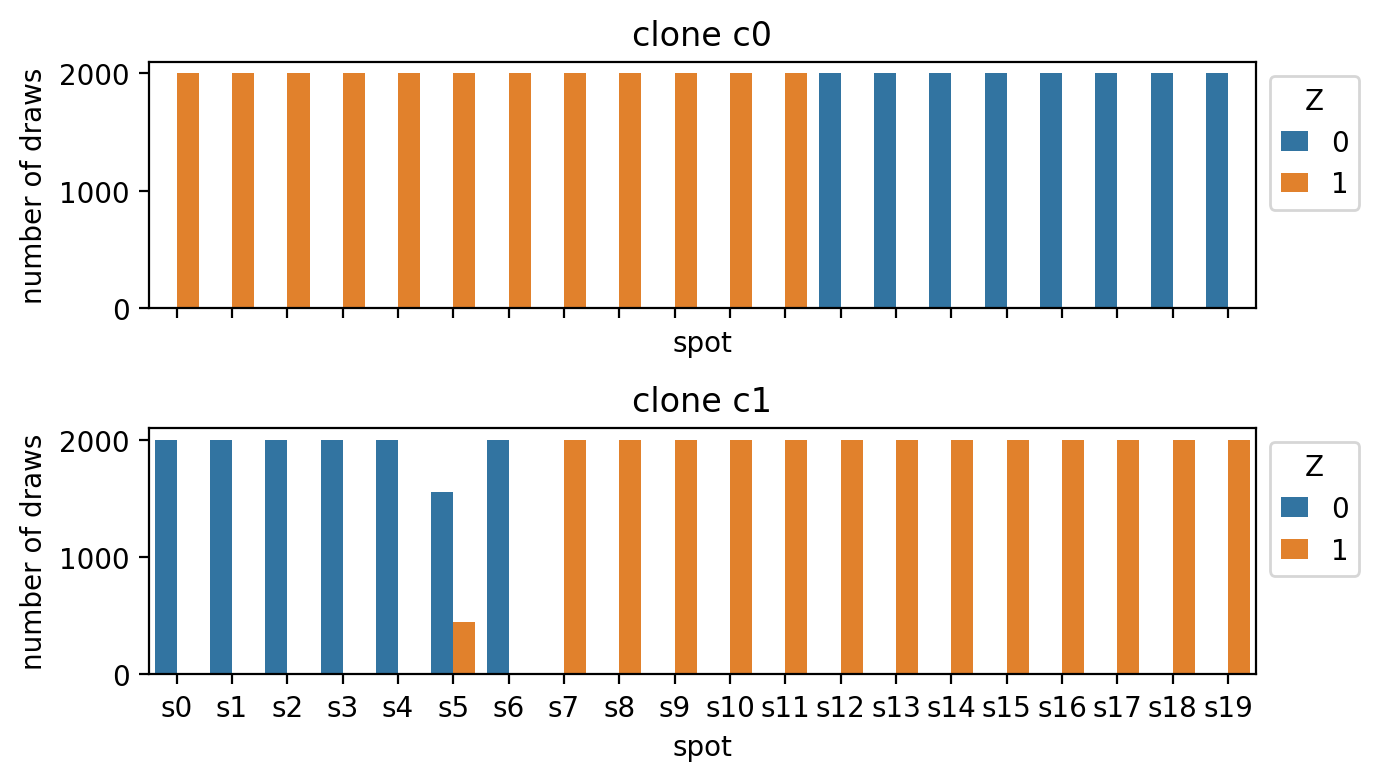

In [30]:
Z_dist = (
    sim_trace.posterior["Z"]
    .to_dataframe()
    .reset_index()
    .groupby(["spot", "clone", "Z"])["draw"]
    .count()
    .reset_index()
)
Z_dist["spot"] = pd.Categorical(Z_dist["spot"], sim_trace.posterior.coords["spot"])

fig, axes = plt.subplots(
    nrows=2, ncols=ceil(sim_data.K / 2), figsize=(7, 4), sharex=True
)
for ax, (clone, Z_dist_k) in zip(axes.flatten(), Z_dist.groupby("clone")):
    ax.set_title(f"clone {clone}")
    sns.barplot(data=Z_dist_k, x="spot", y="draw", hue="Z", ax=ax)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Z", handlelength=1)
    ax.set_xlabel("spot")
    ax.set_ylabel("number of draws")

fig.tight_layout()
plt.show()

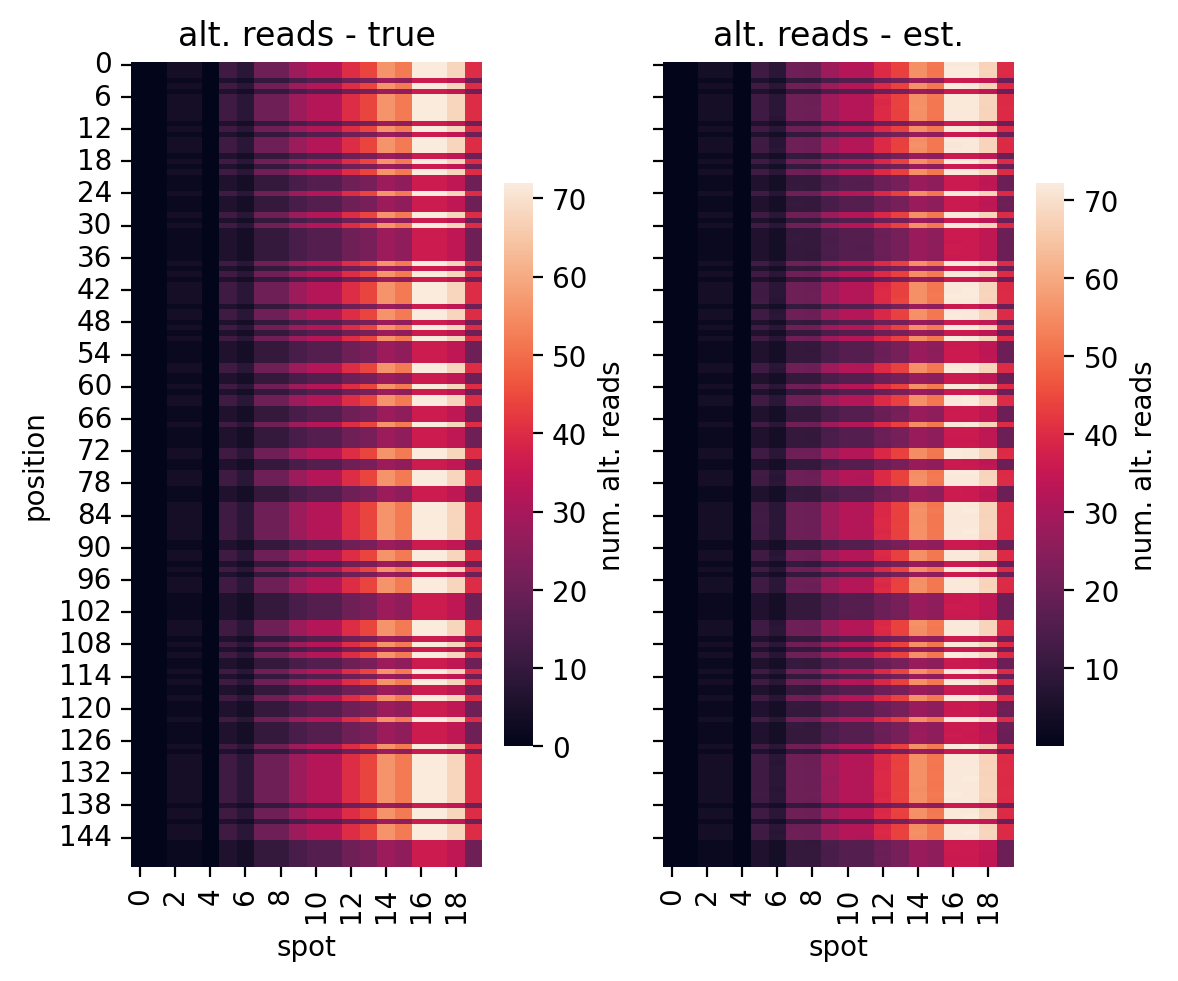

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 5), sharey=True)
A_prob = sim_trace.posterior_predictive["A"].mean(dim=("chain", "draw")).values
# axes[0].imshow(A_prob)
sns.heatmap(
    sim_data.A_obs, ax=axes[0], cbar_kws={"shrink": 0.7, "label": "num. alt. reads"}
)
sns.heatmap(A_prob, ax=axes[1], cbar_kws={"shrink": 0.7, "label": "num. alt. reads"})
axes[0].set_xlabel("spot")
axes[1].set_xlabel("spot")
axes[0].set_ylabel("position")

axes[0].set_title("alt. reads - true")
axes[1].set_title("alt. reads - est.")
fig.tight_layout()

---

## Session information

In [32]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-11

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: tumoroscope-tweaks

pymc      : 4.2.1
seaborn   : 0.12.0
pandas    : 1.5.0
numpy     : 1.23.3
matplotlib: 3.6.0
arviz     : 0.12.1
janitor   : 0.22.0
aesara    : 2.8.6
scipy     : 1.9.1

